<a href="https://colab.research.google.com/github/dit21dsc/Image-coloring/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import keras
from tensorflow.keras.utils  import array_to_img, img_to_array, load_img
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.models import Sequential, Model
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
#OPTIMIZER
from tensorflow.keras.optimizers import RMSprop
import random

In [3]:
from keras.layers import Conv2D,BatchNormalization , ReLU , Conv2DTranspose

In [4]:
Gray_DS = np.load("/content/drive/MyDrive/gray_scale.npy")
AB_1_NPY = np.load("/content/drive/MyDrive/ab1.npy")
AB_2_NPY = np.load("/content/drive/MyDrive/ab2.npy")
AB_3_NPY = np.load("/content/drive/MyDrive/ab3.npy")
AB_DS = np.concatenate([AB_1_NPY, AB_2_NPY, AB_3_NPY], axis=0)



In [5]:
print(type(Gray_DS))
print(type(AB_DS))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
print(Gray_DS.shape)
print(AB_DS.shape)

(25000, 224, 224)
(25000, 224, 224, 2)


In [7]:
start_split = 2000
end_split = 2500
end_non_seen= 3000
dataset_count = 500

In [8]:
X_Train = Gray_DS[start_split:end_split,:,:].astype("float32").reshape(dataset_count,Gray_DS.shape[1],Gray_DS.shape[2])

In [9]:
X_Hidden = Gray_DS[end_split:end_non_seen,:,:].astype("float32").reshape(dataset_count,Gray_DS.shape[1],Gray_DS.shape[2])

In [10]:
Y_Train = AB_DS[start_split:end_split,:,:].astype("float32")

In [11]:
print(X_Train.shape)
print(X_Hidden.shape)
print(Y_Train.shape)

(500, 224, 224)
(500, 224, 224)
(500, 224, 224, 2)


In [12]:
def image_row(gray_img,splitting=dataset_count,inp_function=preprocess_input):
    Empty_imp = np.zeros((splitting,224,224,3))
    for indexing in range(0,3):
        Empty_imp[:splitting,:,:,indexing] = gray_img[:splitting]
        
    return inp_function(Empty_imp)

In [13]:
Inp_Img = image_row(X_Train,dataset_count)

Hidden_inp = image_row(X_Hidden,dataset_count)



In [14]:
print(Inp_Img.shape)
print(Hidden_inp.shape)

(500, 224, 224, 3)
(500, 224, 224, 3)


In [15]:
def tranf_lab_to_rgb(gray_img,ab_images,n=10):
    Empty_imp = np.zeros((n,224,224,3))
    
    Empty_imp[:,:,:,0] = gray_img[0:n:]
    Empty_imp[:,:,:,1:] = ab_images[0:n:]
    
    Empty_imp = Empty_imp.astype("uint8")
    
    Main_Img = []
    
    for indexing in range(0,n):
        Main_Img.append(cv2.cvtColor(Empty_imp[indexing],cv2.COLOR_LAB2RGB))
        
    Main_Img = np.array(Main_Img)
    
    return Main_Img

In [16]:
Output_img = preprocess_input(tranf_lab_to_rgb(X_Train,Y_Train,n=dataset_count))

print(Output_img.shape)

(500, 224, 224, 3)


In [17]:
Gray_emp_imp = np.zeros((dataset_count,Gray_DS.shape[1],Gray_DS.shape[2],1))
Gray_emp_imp[:,:,:,0] = X_Train
print(Gray_emp_imp.shape)

(500, 224, 224, 1)


In [18]:
compile_loss = "mse"
compile_optimizer = RMSprop(learning_rate=0.0001,decay=1e-8)
compile_metrics = ["accuracy"]
input_dim = (Inp_Img.shape[1],Inp_Img.shape[2],Inp_Img.shape[3])
output_class = 1

In [19]:
Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [20]:
Enc_Gray = Sequential()
Enc_Gray.add(Conv2D(32,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Enc_Gray.add(BatchNormalization())
Enc_Gray.add(ReLU())

In [21]:
Enc_Gray.add(Conv2D(64,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Enc_Gray.add(BatchNormalization())
Enc_Gray.add(ReLU())
#

In [22]:
Enc_Gray.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Enc_Gray.add(BatchNormalization())
Enc_Gray.add(ReLU())


In [23]:

Enc_Gray.add(Conv2D(256,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Enc_Gray.add(BatchNormalization())
Enc_Gray.add(ReLU())

In [24]:
Dec_Gray = Sequential()
Dec_Gray.add(Conv2DTranspose(128,(2,2),padding = "same",use_bias = True))
Dec_Gray.add(ReLU())
#

In [25]:
Dec_Gray.add(Conv2DTranspose(64,(2,2),padding = "same",use_bias = True))
Dec_Gray.add(ReLU())
#

In [26]:
Dec_Gray.add(Conv2DTranspose(32,(2,2),padding = "same",use_bias = True))
Dec_Gray.add(ReLU())
#

In [27]:
Dec_Gray.add(Conv2DTranspose(3,(2,2),padding = "same",use_bias = True))
Dec_Gray.add(ReLU())

In [28]:
Exec_Encoder = Sequential([Enc_Gray,Dec_Gray])
Exec_Encoder.compile(loss=compile_loss,optimizer=compile_optimizer,metrics=compile_metrics)
Exec_Encoder_Model = Exec_Encoder.fit(Inp_Img,Output_img,epochs=25,callbacks=[Stopper,Checkpoint],batch_size=8)

Epoch 1/25
63/63 [==============================] - 37s 361ms/step - loss: 0.3106 - accuracy: 0.5479
Epoch 2/25
63/63 [==============================] - 22s 348ms/step - loss: 0.2912 - accuracy: 0.5622
Epoch 3/25
63/63 [==============================] - 22s 354ms/step - loss: 0.2910 - accuracy: 0.5683
Epoch 4/25
63/63 [==============================] - 22s 350ms/step - loss: 0.2913 - accuracy: 0.5670
Epoch 5/25
63/63 [==============================] - 22s 347ms/step - loss: 0.2888 - accuracy: 0.5727
Epoch 6/25
63/63 [==============================] - 22s 349ms/step - loss: 0.2898 - accuracy: 0.5727
Epoch 7/25
63/63 [==============================] - 22s 353ms/step - loss: 0.2887 - accuracy: 0.5761
Epoch 8/25
63/63 [==============================] - 22s 351ms/step - loss: 0.2872 - accuracy: 0.5734
Epoch 9/25
63/63 [==============================] - 22s 351ms/step - loss: 0.2873 - accuracy: 0.5675
Epoch 10/25
63/63 [==============================] - 22s 349ms/step - loss: 0.2865 - accura

In [29]:
#PREDICTION

Predict_img = Exec_Encoder.predict(Inp_Img[:100])

Predict_Hidden = Exec_Encoder.predict(Hidden_inp[:100])

print(Predict_img[5].shape)
print(Predict_Hidden[5].shape)

(224, 224, 3)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'AUTO ENCODER OUTPUT')

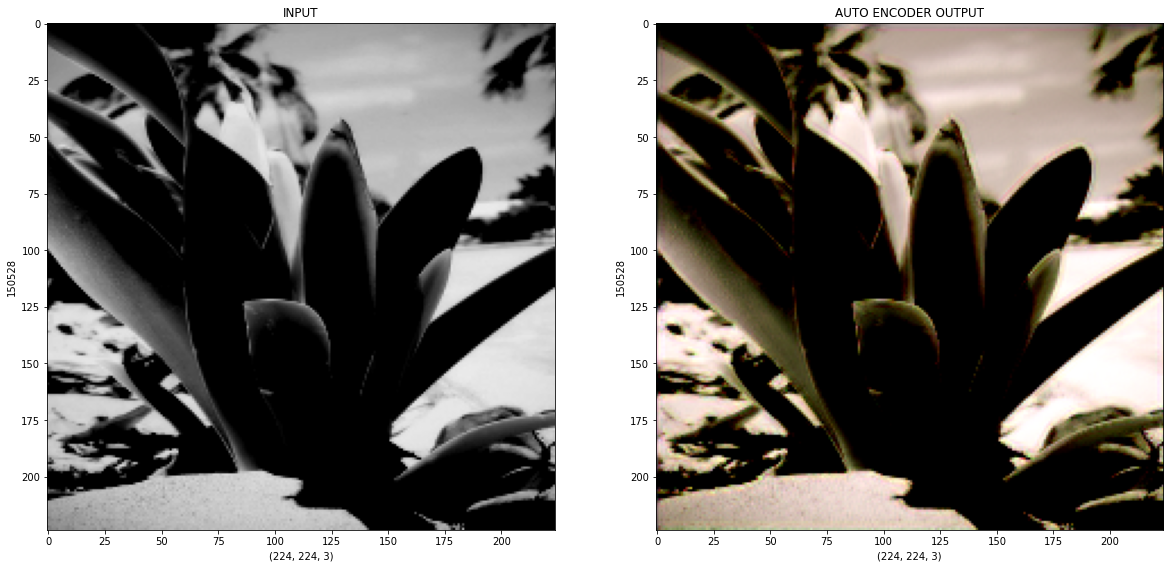

In [58]:
figure,axis = plt.subplots(1,2,figsize=(20,20))
img_number = random.randint(0,99)

Original_Img = Inp_Img[img_number]
Predict_Image_AE = Predict_img[img_number]
axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("INPUT")
axis[1].imshow(Predict_Image_AE)
axis[1].set_xlabel(Predict_Image_AE.shape)
axis[1].set_ylabel(Predict_Image_AE.size)
axis[1].set_title("AUTO ENCODER OUTPUT")
